# Toxic comments classification challenge

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import sklearn
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter
from wordcloud import WordCloud
import emoji
import demoji
import contractions
from textblob import TextBlob

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Embedding, Input, Bidirectional, GlobalMaxPool1D, Dropout

## Data exploration

In [7]:
train_df = pd.read_csv('C:/Users/lilia/OneDrive/Documents/S2 ENSAE/NLP/Project/train.csv')

In [8]:
test_df = pd.read_csv('C:/Users/lilia/OneDrive/Documents/S2 ENSAE/NLP/Project/test.csv')

In [9]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [10]:
train_df.shape

(159571, 8)

In [11]:
train_df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [12]:
train_df.dtypes

id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
dtype: object

In [13]:
train_df.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,159571,159571,2dcc101bcac2ba35,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
comment_text,159571,159571,"""==GA Review==\n\n:This review is transcluded ...",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
toxic,159571.0,NaN,NaN,NaN,0.095844,0.294379,0.0,0.0,0.0,0.0,1.0
severe_toxic,159571.0,NaN,NaN,NaN,0.009996,0.099477,0.0,0.0,0.0,0.0,1.0
obscene,159571.0,NaN,NaN,NaN,0.052948,0.223931,0.0,0.0,0.0,0.0,1.0
threat,159571.0,NaN,NaN,NaN,0.002996,0.05465,0.0,0.0,0.0,0.0,1.0
insult,159571.0,NaN,NaN,NaN,0.049364,0.216627,0.0,0.0,0.0,0.0,1.0
identity_hate,159571.0,NaN,NaN,NaN,0.008805,0.09342,0.0,0.0,0.0,0.0,1.0


In [14]:
print("Check for missing values in Train dataset")
print(train_df.isnull().sum())
print()
print("Check for missing values in Test dataset")
print(test_df.isnull().sum())

Check for missing values in Train dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

Check for missing values in Test dataset
id              0
comment_text    0
dtype: int64


In [15]:
x=train_df.iloc[:,2:].sum()

rowsums=train_df.iloc[:,2:].sum(axis=1)
train_df['clean']=(rowsums==0)

train_df['clean'].sum()
print("Total comments = ",len(train_df))
print("Total clean comments = ",train_df['clean'].sum())
print("Total toxic comments = ",len(train_df[train_df['clean']!=1]))
print("Total tags =",x.sum())

Total comments =  159571
Total clean comments =  143346
Total toxic comments =  16225
Total tags = 35098


## Data visualization

In [37]:
types = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

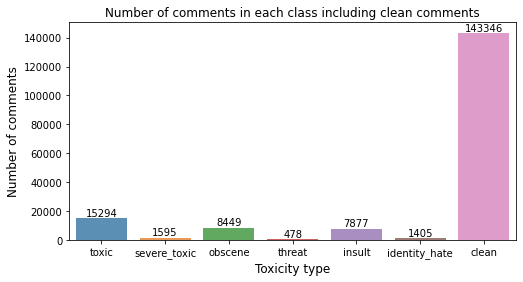

In [38]:
x = train_df.iloc[:,2:].sum()

plt.figure(figsize=(8,4))
ax= sns.barplot(x=x.index, y=x.values, alpha=0.8)
plt.title("Number of comments in each class including clean comments")
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Toxicity type', fontsize=12)

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

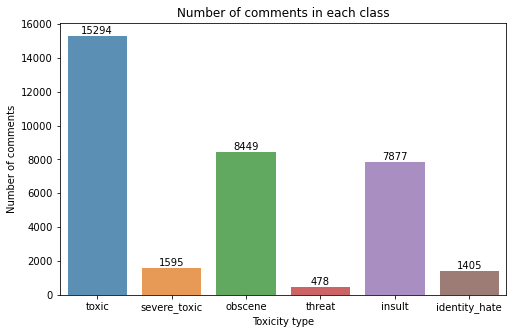

In [39]:
val_counts = train_df[types].sum()

plt.figure(figsize=(8,5))
ax = sns.barplot(x=val_counts.index, y=val_counts.values, alpha=0.8)

plt.title("Number of comments in each class")
plt.xlabel("Toxicity type")
plt.ylabel("Number of comments")

rects = ax.patches
labels = val_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height+5, label, ha="center", va="bottom")
    
plt.show()

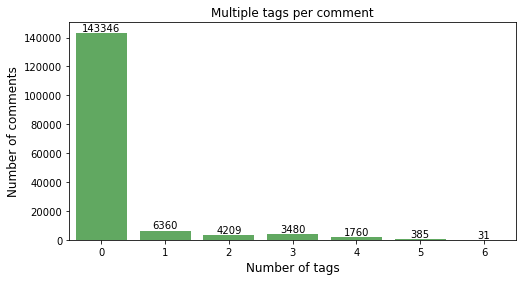

In [40]:
x=rowsums.value_counts()

plt.figure(figsize=(8,4))
ax = sns.barplot(x=x.index, y=x.values, alpha=0.8,color=color[2])
plt.title("Multiple tags per comment")
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Number of tags', fontsize=12)

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

<AxesSubplot:>

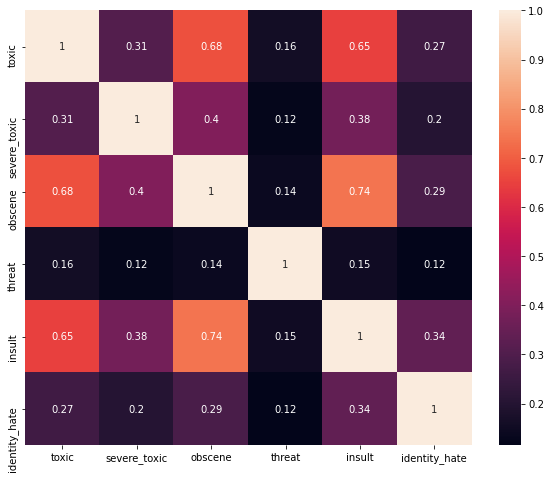

In [41]:
temp_df = train_df.iloc[:,2:-1]
corr=temp_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

In [42]:
# Comments in capitals
train_df['capitals'] = train_df['comment_text'].apply(lambda x: sum(1 for c in x if c.isupper()))

# Number of punctuations in comments
train_df['punctuations'] = train_df['comment_text'].apply(lambda x: sum(1 for c in x if c in string.punctuation))

# Number of emojis in comments
train_df['emojis'] = train_df['comment_text'].apply(lambda comment: sum(comment.count(s) for s in emoji.UNICODE_EMOJI))

In [43]:
# Number of characters in comments
train_df['length'] = train_df['comment_text'].apply(len)
test_df['length'] = test_df['comment_text'].apply(len)

# Number of sentences
train_df['sentences'] = train_df["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1)
test_df['sentences'] = test_df["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1)

# Number of words
train_df['words'] = train_df["comment_text"].apply(lambda x: len(str(x).split()))
test_df['words'] = test_df["comment_text"].apply(lambda x: len(str(x).split()))

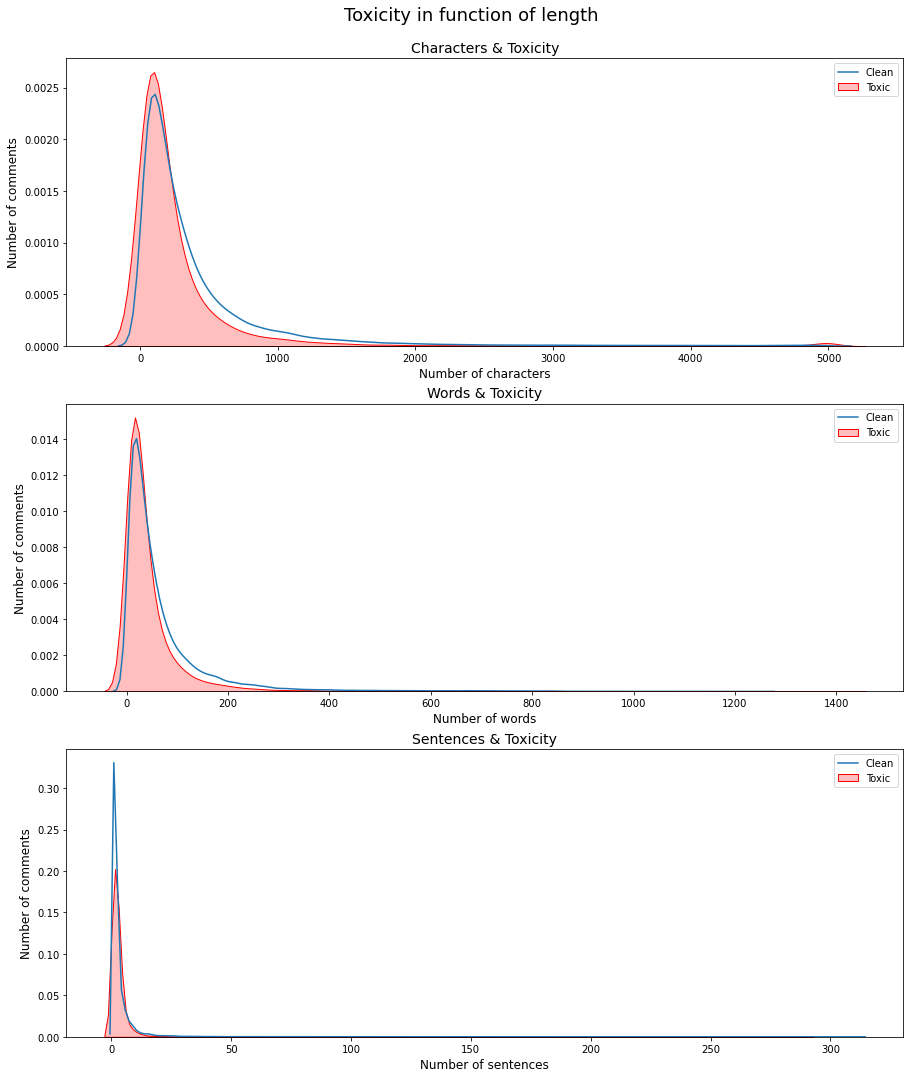

In [44]:
plt.figure(figsize=(15,18))
plt.suptitle("Toxicity in function of length",y=0.92,fontsize=18)
plt.tight_layout()

# Number of characters
plt.subplot(311)
ax=sns.kdeplot(train_df[train_df.clean == 0].length, label="Toxic", shade=True, color='r')
ax=sns.kdeplot(train_df[train_df.clean == 1].length, label="Clean")
plt.legend()
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Number of characters', fontsize=12)
plt.title("Characters & Toxicity", fontsize=14)

# Number of words
plt.subplot(312)
ax=sns.kdeplot(train_df[train_df.clean == 0].words, label="Toxic", shade=True, color='r')
ax=sns.kdeplot(train_df[train_df.clean == 1].words, label="Clean")
plt.legend()
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Number of words', fontsize=12)
plt.title("Words & Toxicity", fontsize=14)

# Number of sentences
plt.subplot(313)
ax=sns.kdeplot(train_df[train_df.clean == 0].sentences, label="Toxic", shade=True, color='r')
ax=sns.kdeplot(train_df[train_df.clean == 1].sentences, label="Clean")
plt.legend()
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Number of sentences', fontsize=12)
plt.title("Sentences & Toxicity", fontsize=14)

plt.show()

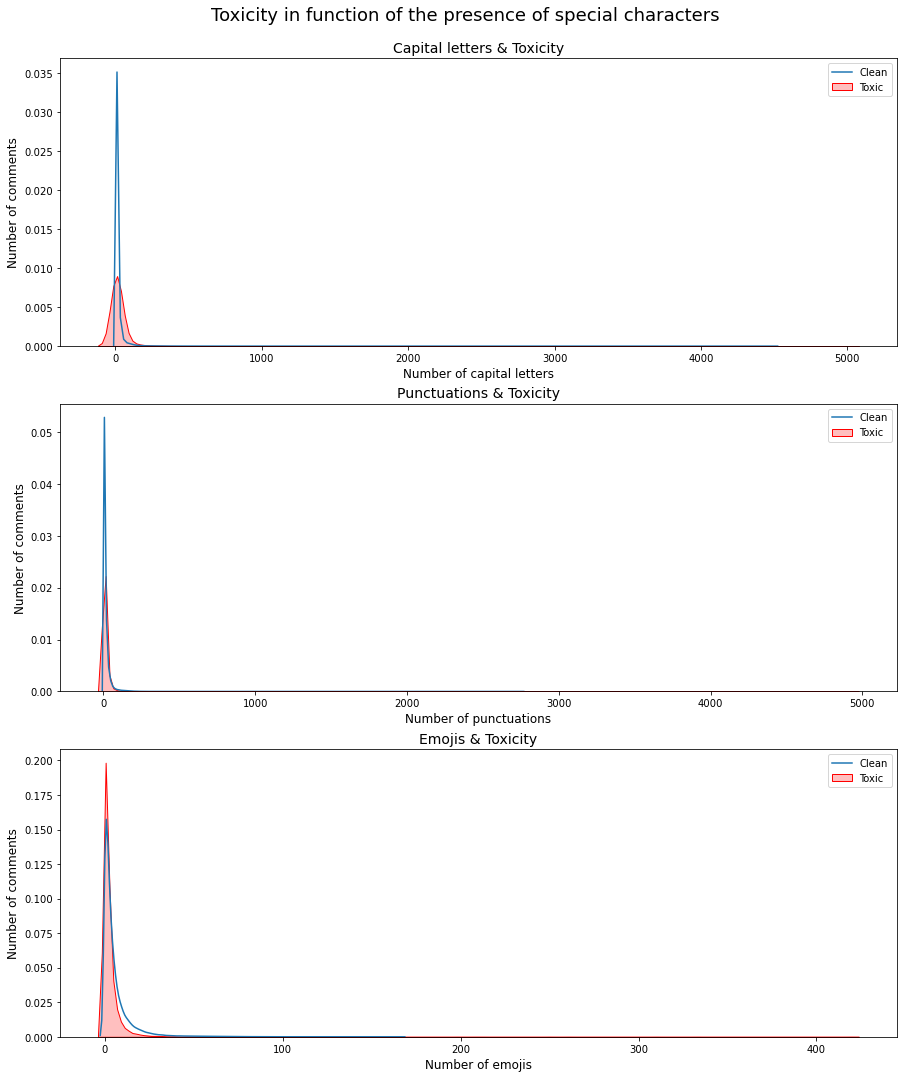

In [45]:
plt.figure(figsize=(15,18))
plt.suptitle("Toxicity in function of the presence of special characters",y=0.92,fontsize=18)
plt.tight_layout()

plt.subplot(311)
ax=sns.kdeplot(train_df[train_df.clean == 0].capitals, label="Toxic", shade=True, color='r')
ax=sns.kdeplot(train_df[train_df.clean == 1].capitals, label="Clean")
plt.legend()
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Number of capital letters', fontsize=12)
plt.title("Capital letters & Toxicity", fontsize=14)

plt.subplot(312)
ax=sns.kdeplot(train_df[train_df.clean == 0].punctuations, label="Toxic", shade=True, color='r')
ax=sns.kdeplot(train_df[train_df.clean == 1].punctuations, label="Clean")
plt.legend()
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Number of punctuations', fontsize=12)
plt.title("Punctuations & Toxicity", fontsize=14)

plt.subplot(313)
ax=sns.kdeplot(train_df[train_df.clean == 0].emojis, label="Toxic", shade=True, color='r')
ax=sns.kdeplot(train_df[train_df.clean == 1].emojis, label="Clean")
plt.legend()
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Number of emojis', fontsize=12)
plt.title("Emojis & Toxicity", fontsize=14)

plt.show()

## Data pre-processing

In [66]:
train_df = train_df.drop(['id'], axis=1)
test_df = test_df.drop(['id'], axis=1)

#### Lowercase, contractions, URL, HTML, non-ASCII, punctuations, emojis, mispelling correction, stopwords

In [16]:
train_df["clean_comments"] = train_df["comment_text"].apply(lambda x: x.lower())

In [17]:
train_df["clean_comments"] = train_df["clean_comments"].apply(lambda x: contractions.fix(x))

In [18]:
def remove_URL(text):
    return re.sub(r"https?://\S+|www\.\S+", "", text)

def remove_html(text):
    html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    return re.sub(html, "", text)

def remove_non_ascii(text):
    return re.sub(r'[^\x00-\x7f]',r'', text)

def remove_special_characters(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F' 
        u'\U0001F300-\U0001F5FF'  
        u'\U0001F680-\U0001F6FF'  
        u'\U0001F1E0-\U0001F1FF' 
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_punct(text):
    return text.translate(str.maketrans('', '', string.punctuation))

In [19]:
train_df["clean_comments"] = train_df["clean_comments"].apply(lambda x: remove_URL(x))

In [20]:
train_df["clean_comments"] = train_df["clean_comments"].apply(lambda x: remove_html(x))

In [21]:
train_df["clean_comments"] = train_df["clean_comments"].apply(lambda x: remove_non_ascii(x))

demoji.download_codes() 
def replace_emojis(sms):
    emojis = demoji.findall(sms)
    for k,v in emojis.items():
        sms = sms.replace(k, v)
    return sms

train_df['clean_comments'] = train_df['clean_comments'].apply(lambda x: replace_emojis(x))

In [22]:
train_df["clean_comments"] = train_df["clean_comments"].apply(lambda x: remove_punct(x))

In [ ]:
## trop long pour corriger les erreurs ....
#train_df["clean_comments"] = train_df["clean_comments"].apply(lambda x: TextBlob(x).correct())

In [23]:
stop = set(stopwords.words('english'))
train_df['clean_comments'] = train_df['clean_comments'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))

In [26]:
test_df["clean_comments"] = test_df["comment_text"].apply(lambda x: x.lower())
test_df["clean_comments"] = test_df["clean_comments"].apply(lambda x: contractions.fix(x))
test_df["clean_comments"] = test_df["clean_comments"].apply(lambda x: remove_URL(x))
test_df["clean_comments"] = test_df["clean_comments"].apply(lambda x: remove_html(x))
test_df["clean_comments"] = test_df["clean_comments"].apply(lambda x: remove_non_ascii(x))
test_df["clean_comments"] = test_df["clean_comments"].apply(lambda x: remove_punct(x))
test_df["clean_comments"] = test_df["clean_comments"].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))

#### Again some data visualizations : wordclouds

In [85]:
word_counter = {}

for categ in types:
    d = Counter()
    train_df[train_df[categ] == 1]['clean_comments'].apply(lambda t: d.update(t.split()))
    word_counter[categ] = pd.DataFrame.from_dict(d, orient='index')\
                                        .rename(columns={0: 'count'})\
                                        .sort_values('count', ascending=False)

In [89]:
%matplotlib inline

(-0.5, 399.5, 199.5, -0.5)

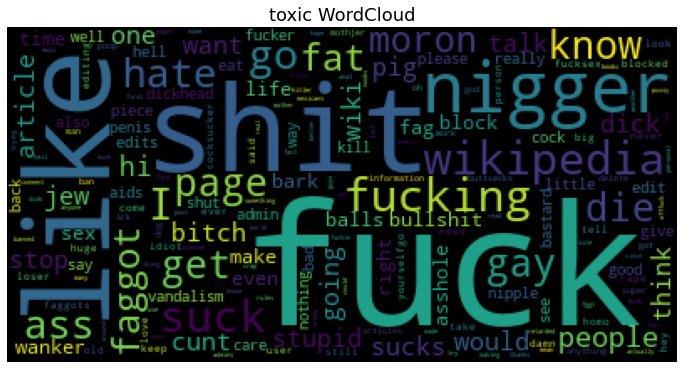

In [96]:
w = 'toxic'
wc = word_counter[w]

wordcloud = WordCloud(
          background_color='black',
          max_words=200,
          max_font_size=100, 
          random_state=4561
         ).generate_from_frequencies(wc.to_dict()['count'])

fig = plt.figure(figsize=(12, 8))
plt.title(w + ' WordCloud', fontsize = 18)
plt.imshow(wordcloud)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

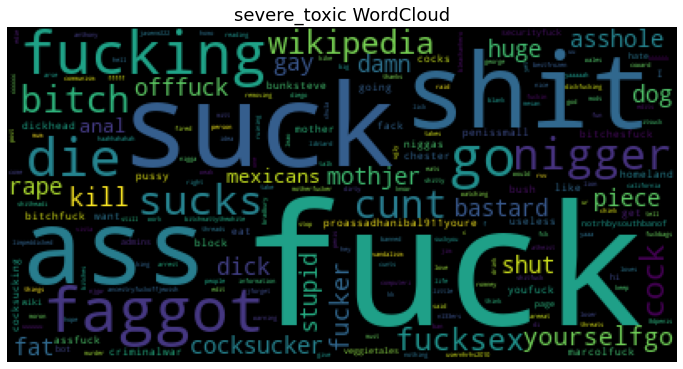

In [97]:
w = 'severe_toxic'
wc = word_counter[w]

wordcloud = WordCloud(
          background_color='black',
          max_words=200,
          max_font_size=100, 
          random_state=4561
         ).generate_from_frequencies(wc.to_dict()['count'])

fig = plt.figure(figsize=(12, 8))
plt.title(w + ' WordCloud', fontsize = 18)
plt.imshow(wordcloud)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

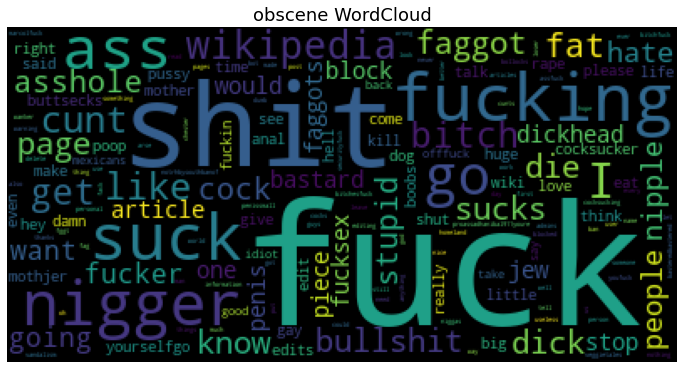

In [98]:
w = 'obscene'
wc = word_counter[w]

wordcloud = WordCloud(
          background_color='black',
          max_words=200,
          max_font_size=100, 
          random_state=4561
         ).generate_from_frequencies(wc.to_dict()['count'])

fig = plt.figure(figsize=(12, 8))
plt.title(w + ' WordCloud', fontsize = 18)
plt.imshow(wordcloud)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

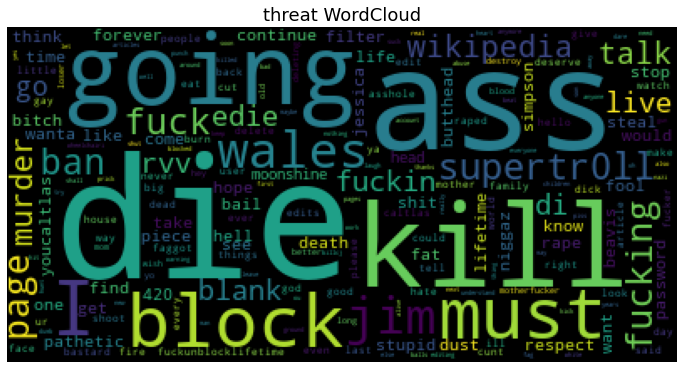

In [99]:
w = 'threat'
wc = word_counter[w]

wordcloud = WordCloud(
          background_color='black',
          max_words=200,
          max_font_size=100, 
          random_state=4561
         ).generate_from_frequencies(wc.to_dict()['count'])

fig = plt.figure(figsize=(12, 8))
plt.title(w + ' WordCloud', fontsize = 18)
plt.imshow(wordcloud)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

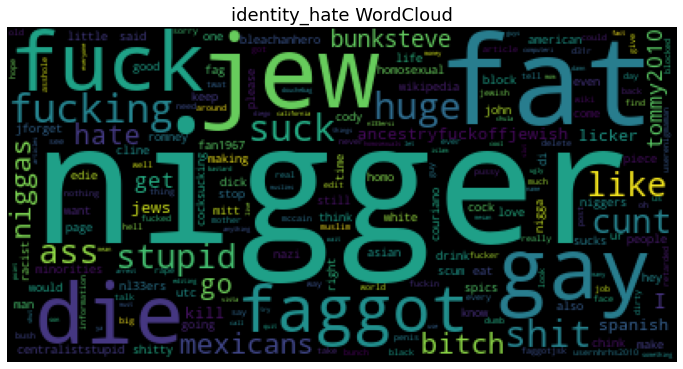

In [100]:
w = 'identity_hate'
wc = word_counter[w]

wordcloud = WordCloud(
          background_color='black',
          max_words=200,
          max_font_size=100, 
          random_state=4561
         ).generate_from_frequencies(wc.to_dict()['count'])

fig = plt.figure(figsize=(12, 8))
plt.title(w + ' WordCloud', fontsize = 18)
plt.imshow(wordcloud)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

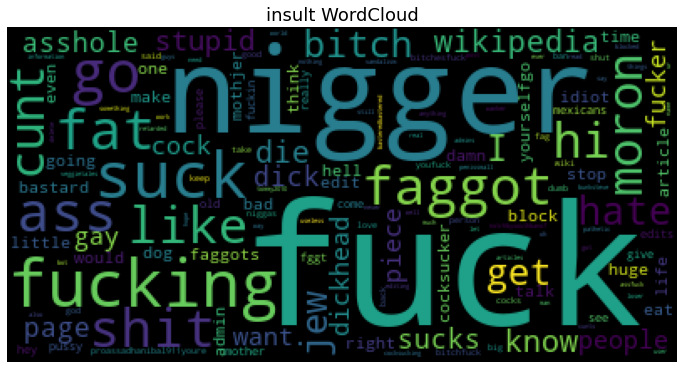

In [101]:
w = 'insult'
wc = word_counter[w]

wordcloud = WordCloud(
          background_color='black',
          max_words=200,
          max_font_size=100, 
          random_state=4561
         ).generate_from_frequencies(wc.to_dict()['count'])

fig = plt.figure(figsize=(12, 8))
plt.title(w + ' WordCloud', fontsize = 18)
plt.imshow(wordcloud)
plt.axis('off')

# Test modèle

In [32]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train_df[list_classes].values
list_sentences_train = train_df["clean_comments"]
list_sentences_test = test_df["clean_comments"]

In [33]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [34]:
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [35]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

In [37]:
inp = Input(shape=(maxlen, )) #maxlen=200 as defined earlier
embed_size = 128
x = Embedding(max_features, embed_size)(inp)

In [38]:
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)

In [41]:
x = GlobalMaxPool1D()(x)

In [44]:
x = Dropout(0.1)(x)

In [45]:
x = Dense(50, activation="relu")(x)

In [46]:
x = Dropout(0.1)(x)

In [47]:
x = Dense(6, activation="sigmoid")(x)

In [50]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [51]:
## ASSEZ LENT, JE PREVIENS
batch_size = 32
epochs = 2
model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/2
4488/4488 [==============================] - 648s 144ms/step - loss: 0.0714 - accuracy: 0.9357 - val_loss: 0.0522 - val_accuracy: 0.9940
Epoch 2/2
4488/4488 [==============================] - 542s 121ms/step - loss: 0.0460 - accuracy: 0.9869 - val_loss: 0.0498 - val_accuracy: 0.9925


In [52]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 128)          2560000   
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           45360     
_________________________________________________________________
global_max_pooling1d (Global (None, 60)                0         
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                3050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)               

# Pour chaque étape, je vais créer une colonne et on verra à quoi ça servira au fur et à mesure !
## Colonne avec les commentaires tokenisés

## Colonne après un Porter Stemmer

In [103]:
def porter_stemmer(text):
    stemmer = nltk.PorterStemmer()
    stems = [stemmer.stem(i) for i in text]
    return stems

In [105]:
#train_df['stemmed_text'] = train_df['tokenized_comments'].apply(lambda x: porter_stemmer(x))